### Import Libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import re

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random

## Data Management

### Alphabets Setup

In [0]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [0]:
len(eng_alpha2index)

27

In [0]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [0]:
len(hindi_alpha2index)

129

In [0]:
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

## Dataset Loading

In [0]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            # Skip noisy data
            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))
    
    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch

In [0]:
train_data = TransliterationDataLoader('rI58TOlAScioEuPBbOYh_NEWS2012TrainingEnHi13937-1563719470862.xml')
test_data = TransliterationDataLoader('njThAK0RQGeoOuE9rfwg_NEWS2012RefEnHi1000-1563719263404.xml')

Skipping:  BARHARWA JUNCTION  -  बरहरवा
Skipping:  STATE BNK TR  -  स्टेट बैंक ऑफ त्रावणकोर
Skipping:  SOUTH ARLINGTON CHURCH OF CHRIST  -  साउथ अर्लिंग्टन
Skipping:  KING EDWARD VII  -  किंग एडवर्ड
Skipping:  DIBANG VALLEY  -  दिबंगवैली
Skipping:  ORDER OF VASA  -  ऑडर ऑफ़ द वासा
Skipping:  AZAMNAGAR ROAD  -  आज़मनगर
Skipping:  CAPE TOWN  -  केपटाउन
Skipping:  NEW ZEALAND  -  न्यूज़ीलैंड
Skipping:  SEA OF THE HEBRIDES  -  सी ऑफ हरब्रिड्‍स
Skipping:  RAMCOIND  -  राम्को इंड
Skipping:  KELVINGROVE ART GALLERY AND MUSEUM  -  केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping:  AUSTRALIAN NATIONAL UNIVERSITY  -  ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping:  JAHAN AARA  -  जहाँआरा
Skipping:  NAVABHARAT FERRO ALLOYS  -  नव भारत फ़ैरो अलॉय
Skipping:  RAMA LINGESHWARA  -  रामालिंगेश्वर
Skipping:  FAKHRUN NISA  -  फखरुन्निसा
Skipping:  REDIFF.COM INDIA LIMITED  -  रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping:  OMKARNATH THAKUR  -  ओंकार नाथ ठाकुर
Skipping:  OPENTV  -  ओपन टीवी
Skipping:  ENVOY COMMUNICATIONS GROUP  

### Basic Data Visualization

In [0]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20543
Test Set Size:	 1000

Sample data from train-set:
LALA - लाला
DA - दा
MANGAL - मंगल
WALKER - वॉकर
SCHOOL - स्कूल
DASI - दासी
ALMODA - अल्मोडा
SUMMER - समर
AMANDEEP - अमनदीप
HIM - हिम


In [0]:
print('\nSample data from test-set:')
for i in range(10):
    eng, hindi = test_data.get_random_sample()
    print(eng + ' - ' + hindi)


Sample data from test-set:
RAHO - रहो
EUGENIA - यूजेनिया
CURTLY - कर्टली
CURTLY - कर्टली
MEXICAN - मैक्सिकन
DEKH - देख
JO - जॉ
TUMHARA - तुम्हारा
MASJID - मस्जिद
MEI - में


In [0]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [0]:
eng, hindi = train_data.get_random_sample()
hindi_rep = word_rep(hindi, hindi_alpha2index)
print(hindi, hindi_rep)

डेली tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [0]:
eng_gt = gt_rep(eng, eng_alpha2index)
print(eng, eng_gt)

DAILY tensor([[ 4],
        [ 1],
        [ 9],
        [12],
        [25],
        [ 0]])


### Encoder-Decoder with Attention 


In [0]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder_Attention_LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention_LSTM, self).__init__()
        
        self.hidden_size = hidden_size # nH
        self.output_size = output_size # nO # nI - Input Size 
        
        self.encoder_rnn_cell = nn.LSTM(input_size, hidden_size)
        self.decoder_rnn_cell = nn.LSTM(hidden_size*2, hidden_size)
        
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
        
        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)   
        
        self.verbose = verbose
        
    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        
        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input) # (word_size,1,129) -> (word_size,1,256),(1,1,256)
        if self.verbose:
            print('Prior Encoder output', encoder_outputs.shape)
            print('hidden.shape',hidden[0].shape)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size) # (word_size,1,256) -> (word_size,256)
        
        if self.verbose:
            print('Encoder output', encoder_outputs.shape)
        
        # decoder
        decoder_state = hidden # (1,1,256)
        decoder_input = torch.zeros(1, 1, self.output_size).to(device) # (1,1,27)
        
        outputs = []
        U = self.U(encoder_outputs) # (word_size,256) -> (word_size,256)
        
        if self.verbose:
            print('Decoder state[0]', decoder_state[0].shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)
        
        for i in range(max_output_chars):
            
            W = self.W(decoder_state[0].view(1, -1).repeat(encoder_outputs.shape[0], 1))# (1,1,256) -> (1,256) -> (word_size,256) -> (word_size,256)
            V = self.attn(torch.tanh(U + W)) # (word_size,256) -> (word_size,1)
            attn_weights = F.softmax(V.view(1, -1), dim = 1) # (1,word_size) # softmax over the encoded inputs
            
            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0), #(1,1,word_size) * (1,word_size,256) -> (1,1,256)
                                 encoder_outputs.unsqueeze(0))

           #  embedding -  (1,1,27) -> (1,1,256)
            embedding = self.out2hidden(decoder_input) # Converting the output of previous timestep to hidden_size
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0) # Concatenating input and context vector
          # decoder_input - (1,512) -> (1,1,512)
            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)
                
            
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state) 
            
            if self.verbose:
                print('Decoder intermediate output', out.shape)
                
            out = self.h2o(decoder_state[0])  # (1,1,256) -> (1,1,27)
            out = self.softmax(out) # (1,1,27)
            outputs.append(out.view(1, -1)) # (1,1,27) -> (1,27)
            
            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False
            
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1) 
            
            decoder_input = one_hot.detach()
            
        return outputs

In [0]:
net_attn_lstm = Transliteration_EncoderDecoder_Attention_LSTM(len(hindi_alpha2index), 256, len(eng_alpha2index), verbose=True)

In [0]:
def infer(model,input_,max_output_chars,show_output=False):
  model.eval().to(device_gpu)
  with torch.no_grad():
    outputs = model(word_rep(input_,hindi_alpha2index,device_gpu),max_output_chars,device_gpu)
    for i in range(len(outputs)):
      output = torch.argmax(outputs[i],dim=1)
      if show_output:
        print(list(eng_alpha2index.keys())[output])
    return outputs

In [0]:
out = infer(net_attn_lstm, 'काला', 30,show_output=True)

Prior Encoder output torch.Size([5, 1, 256])
hidden.shape torch.Size([1, 1, 256])
Encoder output torch.Size([5, 256])
Decoder state[0] torch.Size([1, 1, 256])
Decoder intermediate input torch.Size([1, 1, 27])
U * Encoder output torch.Size([5, 256])
W * Decoder state torch.Size([5, 256])
V torch.Size([5, 1])
Attn torch.Size([1, 5])
Attn LC torch.Size([1, 1, 256])
Decoder input torch.Size([1, 1, 512])
Decoder intermediate output torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 27])
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V
V


### Core Trainer

In [0]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)
    
    total_loss = 0
    for i in range(batch_size):
        
        input = word_rep(hindi_batch[i], hindi_alpha2index, device)
        gt = gt_rep(eng_batch[i], eng_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)
        
        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)  # Aggregating gradients across the decoder output timesteps
            total_loss += loss                  # using retain_graph else graph will be destroyed
        
    opt.step()
    return total_loss/batch_size

## Trainer Helper

In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    torch.save(net, 'model.pt')
    return loss_arr

Iteration 1999 Loss 0.11384555697441101


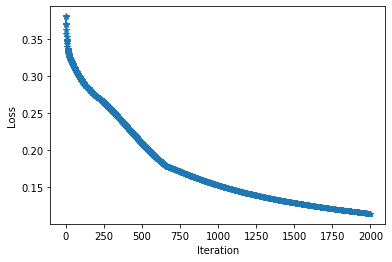




CPU times: user 1h 56min 29s, sys: 2min 32s, total: 1h 59min 1s
Wall time: 1h 59min 33s


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Transliteration_EncoderDecoder_Attention_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be c

array([0.        , 0.36897388, 0.38029277, ..., 0.11386932, 0.11384556,
       0.11382218])

In [0]:
%%time
train_setup(net_attn_lstm, lr=0.001, n_batches=2000, batch_size = 64, display_freq=10, device = device_gpu)

Iteration 199 Loss 0.06133890151977539


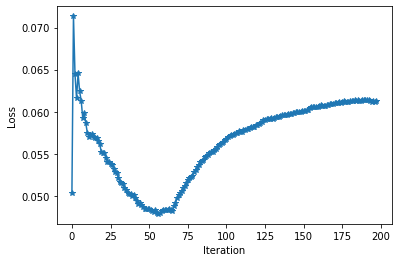




CPU times: user 11min 37s, sys: 15.4 s, total: 11min 53s
Wall time: 11min 56s


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Transliteration_EncoderDecoder_Attention_LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LogSoftmax. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be c

array([0.        , 0.05032725, 0.07133831, 0.06442379, 0.06158269,
       0.06456303, 0.06240682, 0.06132104, 0.05926283, 0.05987208,
       0.0586101 , 0.05749275, 0.05704434, 0.05721448, 0.05741291,
       0.05705861, 0.05687021, 0.05687772, 0.0564871 , 0.05614211,
       0.05525294, 0.05515954, 0.05505874, 0.05448919, 0.05405692,
       0.05408506, 0.05384129, 0.0536423 , 0.0532073 , 0.05287726,
       0.05278396, 0.05218295, 0.0517116 , 0.05150911, 0.05140712,
       0.05097708, 0.05075206, 0.05030865, 0.05019988, 0.05019422,
       0.04997632, 0.05012071, 0.0497988 , 0.04939653, 0.04909827,
       0.04919659, 0.04897019, 0.04864532, 0.04850039, 0.04848431,
       0.04845398, 0.0484133 , 0.04833595, 0.04823016, 0.04805741,
       0.04828046, 0.04802947, 0.04787268, 0.04794984, 0.04819695,
       0.04836131, 0.04838377, 0.04834223, 0.04834418, 0.04840546,
       0.04828964, 0.048165  , 0.04881575, 0.0491281 , 0.04978885,
       0.05009366, 0.05035383, 0.05062699, 0.05098419, 0.05122

In [0]:
%%time
train_setup(net_attn_lstm, lr=0.001, n_batches=200, batch_size = 64, display_freq=10, device = device_gpu)

## Inference

In [0]:
def test(net, word, device = 'cpu'):
    net = net.eval().to(device)
    outputs = infer(net, word, 30)
    eng_output = ''
    for out in outputs:
        val, indices = out.topk(1)
        index = indices.tolist()[0][0]
        if index == 0:
            break
        eng_char = eng_alphabets[index+1]
        eng_output += eng_char
    print(word + ' - ' + eng_output)
    return eng_output

In [0]:
def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = gt_rep(eng, eng_alpha2index, device)
        outputs = infer(net, hindi, gt.shape[0])
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            eng_pos = indices.tolist()[0]
            if eng_pos[0] == gt[index][0]:
                correct += 1
        
        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

#### Load Trained Model

In [0]:
net_attn_lstm = torch.load("./net_attn_hindi2eng_lstm_2.pth")

In [0]:
accuracy_attn = calc_accuracy(net_attn_lstm) * 100
print('Acurracy with attention', accuracy_attn)

Acurracy with attention 76.2535798351976


In [0]:
infer(net_attn_lstm,"उठता",6)

U
T
H
A
T
A


In [0]:
out = infer(net_attn_lstm,"गोंबे",6,show_output=True)

G
O
M
B
E
-PAD-


In [0]:
print('\nSample data from test-set:')
for i in range(10):
    eng, hindi = test_data.get_random_sample()
    print(eng + ' - ' + hindi)


Sample data from test-set:
SUBRAMANYAM - सुब्रमण्यम
ASHOKA - अशोक
KABIRA - कबीरा
ISTVAN - इस्वॉन
JET - जेट
CROWN - क्राउन
GOMBE - गोंबे
RAJESH - राजेश
LAYEGI - लाएगी
INTERCONTINENTAL - इंटरकॉनटिनेंटल
